<a href="https://colab.research.google.com/github/Shubhammawa/Pytorch-Tutorial/blob/master/LeNet5_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torch.nn.functional as F
import time
import scipy

In [20]:
apply_transform = transforms.Compose([transforms.Resize(32),transforms.ToTensor()])
BatchSize = 512 # change according to system specs

trainset = datasets.CIFAR100(root='./CIFAR100', train = True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize, shuffle=True, num_workers=4) # Creating dataloader

testset = datasets.CIFAR100(root='./CIFAR100', train = False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=BatchSize, shuffle=False, num_workers=4) # Creating dataloader

0it [00:00, ?it/s]

100%|█████████▉| 168747008/169001437 [00:16<00:00, 10354037.86it/s]

Files already downloaded and verified


In [47]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainLoader.dataset)))
print('No. of samples in test set: '+str(len(testLoader.dataset)))
train_size = len(trainLoader.dataset)
test_size = len(testLoader.dataset)
print(trainLoader.dataset.data.shape)
print(np.shape(trainLoader.dataset.targets))

No. of samples in train set: 50000
No. of samples in test set: 10000
(50000, 32, 32, 3)
(50000,)


In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3,6,kernel_size = 5)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(6,16,kernel_size = 5)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1,400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

In [24]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)


In [25]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')   
    net = net.cuda()

GPU is available!


In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [0]:
CUDA_LAUNCH_BLOCKING=1

Iteration: 1 /50  ; LeNet:  Training Loss: 0.005926 ; Testing Acc: 20.110 ; Time consumed: 0m 5s 
Iteration: 2 /50  ; LeNet:  Training Loss: 0.005878 ; Testing Acc: 21.060 ; Time consumed: 0m 6s 
Iteration: 3 /50  ; LeNet:  Training Loss: 0.005930 ; Testing Acc: 20.550 ; Time consumed: 0m 6s 
Iteration: 4 /50  ; LeNet:  Training Loss: 0.005949 ; Testing Acc: 20.910 ; Time consumed: 0m 6s 
Iteration: 5 /50  ; LeNet:  Training Loss: 0.005882 ; Testing Acc: 21.330 ; Time consumed: 0m 6s 
Iteration: 6 /50  ; LeNet:  Training Loss: 0.005934 ; Testing Acc: 19.660 ; Time consumed: 0m 6s 
Iteration: 7 /50  ; LeNet:  Training Loss: 0.005875 ; Testing Acc: 19.990 ; Time consumed: 0m 7s 
Iteration: 8 /50  ; LeNet:  Training Loss: 0.005919 ; Testing Acc: 21.630 ; Time consumed: 0m 7s 
Iteration: 9 /50  ; LeNet:  Training Loss: 0.005856 ; Testing Acc: 21.210 ; Time consumed: 0m 6s 
Iteration: 10 /50  ; LeNet:  Training Loss: 0.005842 ; Testing Acc: 21.220 ; Time consumed: 0m 6s 
Iteration: 11 /50  

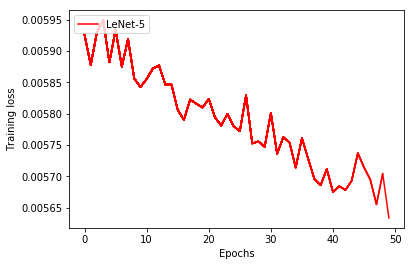

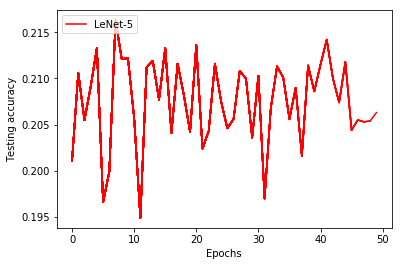

In [53]:
iterations = 50
trainLoss = []
testAcc = []
#i = 0
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0
    net.train(True)
    for data in trainLoader:
        inputs, labels = data
        #i+=1
        # Wrap inputs and labels into Variables
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        # Initialize gradients to zero
        optimizer.zero_grad()
        
        # Feedforward input through the network
        output = net(inputs)
        
        # Compute loss
        loss = criterion(output, labels)
        
        # Backpropagation
        loss.backward()
        
        # Update the network parameters
        optimizer.step()
        
        # Accumulate loss per batch
        runningLoss += loss.data.item()
    avgTrainLoss = runningLoss/train_size
    trainLoss.append(avgTrainLoss)
    
    # Evaluating performance on test set for each epoch
    with torch.no_grad(): # for evaluation
        running_correct = 0
        #j = 0
        for data in testLoader:
            inputs,labels = data
            
            # Wrap them in Variable
            if use_gpu:
                inputs = Variable(inputs.cuda())                
                outputs = net(inputs)
                #j+=1
                #print(outputs,j)              
                _, predicted = torch.max(outputs.data, 1)
                
                predicted = predicted.cpu()
           
            else:
                inputs = Variable(inputs)
                outputs = net(inputs)
                
                _, predicted = torch.max(outputs.data, 1)
                
            running_correct += (predicted == labels).sum()
     
        avgTestAcc = float(running_correct)/test_size
  
        testAcc.append(avgTestAcc)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='LeNet-5')        
           
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc,'r-',label='LeNet-5')        
        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('Iteration: {:.0f} /{:.0f}  ; LeNet:  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//60,epochEnd%60))

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()

In [0]:
# classes = ['beaver', 'dolphin', 'otter', 'seal', 'whale'
# ,'aquarium_fish', 'flatfish', 'ray', 'shark', 'trout', 'orchids', 'poppies', 'roses', 'sunflowers', 'tulips', 'bottles', 'bowls', 'cans', 'cups', 'plates'
# ,'apples', 'mushrooms', 'oranges', 'pears', 'sweet_peppers'
# ,'clock', 'computer_keyboard', 'lamp', 'telephone', 'television'
# ,'bed', 'chair', 'couch', 'table', 'wardrobe'
# ,'bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'
# ,'bear', 'leopard', 'lion', 'tiger', 'wolf'
# ,'bridge', 'castle', 'house', 'road', 'skyscraper'
# ,'cloud', 'forest', 'mountain', 'plain', 'sea'
# ,'camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'
# ,'fox', 'porcupine', 'possum', 'raccoon', 'skunk'
# ,'crab', 'lobster', 'snail', 'spider', 'worm'
# ,'baby', 'boy', 'girl', 'man', 'woman'
# ,'crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'
# ,'hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'
# ,'maple', 'oak', 'palm', 'pine', 'willow'
# ,'bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'
# ,'lawn-mower', 'rocket', 'streetcar', 'tank', 'tractor']
class_idx = np.arange(1,101)
#print(class_idx)

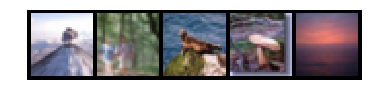

GroundTruth:        50       34       73       52       72
Predicted:   13 (0.14)  64 (0.11)  28 (0.15)  92 (0.11)  72 (0.22)


In [57]:
dataiter = iter(testLoader)
inputs, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(inputs[:5], nrow=5))
print('GroundTruth: ', ' '.join('%8s' % class_idx[labels[j]] for j in range(5)))

# Get the predicted outputs
if use_gpu:
    inputs = Variable(inputs.cuda())                
    outputs = net(inputs)
    probabilities, predicted = torch.max(outputs.data, 1)                
    predicted = predicted.cpu()           
else:
    inputs = Variable(inputs)
    outputs = net(inputs)                
    probabilities, predicted = torch.max(outputs.data, 1)
probabilities_np = probabilities.cpu().data.numpy()
print('Predicted: ', ' '.join('%3s (%.2f)' % (class_idx[predicted[j]], torch.exp(probabilities[j])) for j in range(5)))